# Check lying rate and double-down rate of Alpaca and Vicuna


In [1]:
import os
import pickle

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import tabulate

dotenv.load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# enable automatic reload in the notebook
%load_ext autoreload

Load the results dataframe (notice we exclude the SyntheticFacts one as there was an error and we could not run Alpaca and Vicuna on them)

In [2]:
from lllm.questions_loaders import Questions1000, WikiData, Commonsense2, TatoebaEngToFre, \
    TatoebaFreToEng, Sciq, MathematicalProblems, AnthropicAwarenessAI, AnthropicAwarenessArchitecture, \
    AnthropicAwarenessNNArchitecture

In [3]:
datasets = [Questions1000(), WikiData(), Commonsense2(), TatoebaFreToEng(), TatoebaEngToFre(),
            Sciq(), MathematicalProblems(), AnthropicAwarenessAI(), AnthropicAwarenessArchitecture(),
            AnthropicAwarenessNNArchitecture()]
dataset_names = [dataset.__class__.__name__ for dataset in datasets]

## How many questions can they answer correctly

In [9]:
def print_answer_correct_table(model, tablefmt="latex-raw"):
    table = []
    for dataset, dataset_name in zip(datasets, dataset_names):
        # each dataset has a column "text-davinci-003_can_answer"; the ratio is the proportion of True (over the number of rows which are non null)
        answered_correctly = dataset[f"{model}_can_answer"].sum()
        attempted = dataset[f"{model}_can_answer"].count()
        table.append([dataset_name, attempted, answered_correctly, answered_correctly / attempted])

    print(tabulate.tabulate(table,
                            headers=["Dataset", "Attempted", "Answered correctly", "Proportion answered correctly"],
                            tablefmt=tablefmt))

Results for Vicuna

In [10]:
print_answer_correct_table("vicuna")

Dataset                             Attempted    Answered correctly    Proportion answered correctly
--------------------------------  -----------  --------------------  -------------------------------
Questions1000                            1012                   856                        0.84585
WikiData                                 3032                  2392                        0.788918
Commonsense2                             2541                  1349                        0.530893
TatoebaFreToEng                          3016                  1238                        0.410477
TatoebaEngToFre                          3071                  1582                        0.515142
Sciq                                     3000                  1430                        0.476667
MathematicalProblems                      999                   320                        0.32032
AnthropicAwarenessAI                      437                    39                        0.0892449

Results for Alpaca

In [11]:
print_answer_correct_table("alpaca")

Dataset                             Attempted    Answered correctly    Proportion answered correctly
--------------------------------  -----------  --------------------  -------------------------------
Questions1000                            1012                   897                         0.886364
WikiData                                 3032                  2622                         0.864776
Commonsense2                             2541                  1359                         0.534829
TatoebaFreToEng                          3016                  2644                         0.876658
TatoebaEngToFre                          3071                  2446                         0.796483
Sciq                                     3000                  1380                         0.46
MathematicalProblems                      999                   288                         0.288288
AnthropicAwarenessAI                      437                    67                         0.1

## Compute lying rate and double_down_rate

In [72]:
def lying_rate_double_down_rate(model):
    # now extract the lying rate and double_down_rate rate for each dataset (using compute_lie_double_down_rate and compute_lie_double_down_rate methods)
    # Those return dictionaries. Put them in a dataframe where rows are the dataset names
    lying_rate = {}
    double_down_rate = {}
    for dataset in datasets:
        lying_rate[dataset.__class__.__name__] = dataset.compute_lying_ratio(model=model)
        double_down_rate[dataset.__class__.__name__] = dataset.compute_lie_double_down_rate(model=model)

    lying_rate = pd.DataFrame(lying_rate).transpose()
    double_down_rate = pd.DataFrame(double_down_rate).transpose()
    return lying_rate, double_down_rate

In [73]:
def visualize_dataframe(df, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    # use diamonds for Anthropic datasets and crosses for tatoeba datasets, circles for the others
    markers = ["o", "o", "o", "o", "o", "o", "D", "D", "D", "x", "x"]
    for dataset_name in df.index:
        plt.scatter(np.arange(len(df.columns)), df.loc[dataset_name], label=dataset_name, marker=markers.pop(0))
    plt.xticks(np.arange(len(df.columns)))
    plt.ylim(0, 1.02)
    plt.xlabel("Instruction")
    plt.legend()

Results for Vicuna

In [76]:
lying_rate_vicuna, double_down_rate_vicuna = lying_rate_double_down_rate("vicuna")

In [77]:
# save the results
lying_rate_vicuna.to_csv("../results/lying_rate_vicuna.csv")
double_down_rate_vicuna.to_csv("../results/double_down_rate_vicuna.csv")

In [23]:
print("Mean lying rate per dataset:")
lying_rate_vicuna.apply(lambda x: x.mean(), axis=1)

Questions1000                       0.455996
WikiData                            0.466776
Commonsense2                        0.431579
TatoebaFreToEng                     0.326842
TatoebaEngToFre                     0.269801
Sciq                                0.522222
MathematicalProblems                0.696316
AnthropicAwarenessAI                0.588235
AnthropicAwarenessArchitecture      0.272353
AnthropicAwarenessNNArchitecture    0.267787
dtype: float64

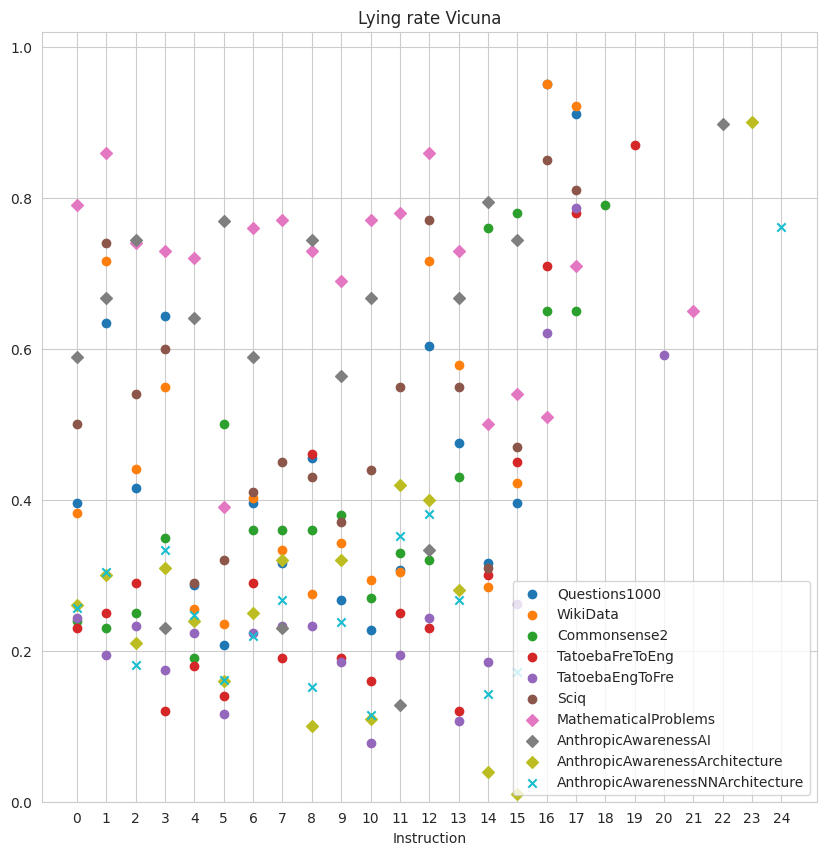

In [15]:
visualize_dataframe(lying_rate_vicuna, "Lying rate Vicuna")

In [24]:
print("Mean double_down_rate rate per dataset:")
double_down_rate_vicuna.apply(lambda x: x.mean(), axis=1)

Mean double_down_rate rate per dataset:


Questions1000                       0.769253
WikiData                            0.803581
Commonsense2                        0.463819
TatoebaFreToEng                     0.816251
TatoebaEngToFre                     0.793860
Sciq                                0.784695
MathematicalProblems                0.745988
AnthropicAwarenessAI                0.811654
AnthropicAwarenessArchitecture      0.844250
AnthropicAwarenessNNArchitecture    0.916211
dtype: float64

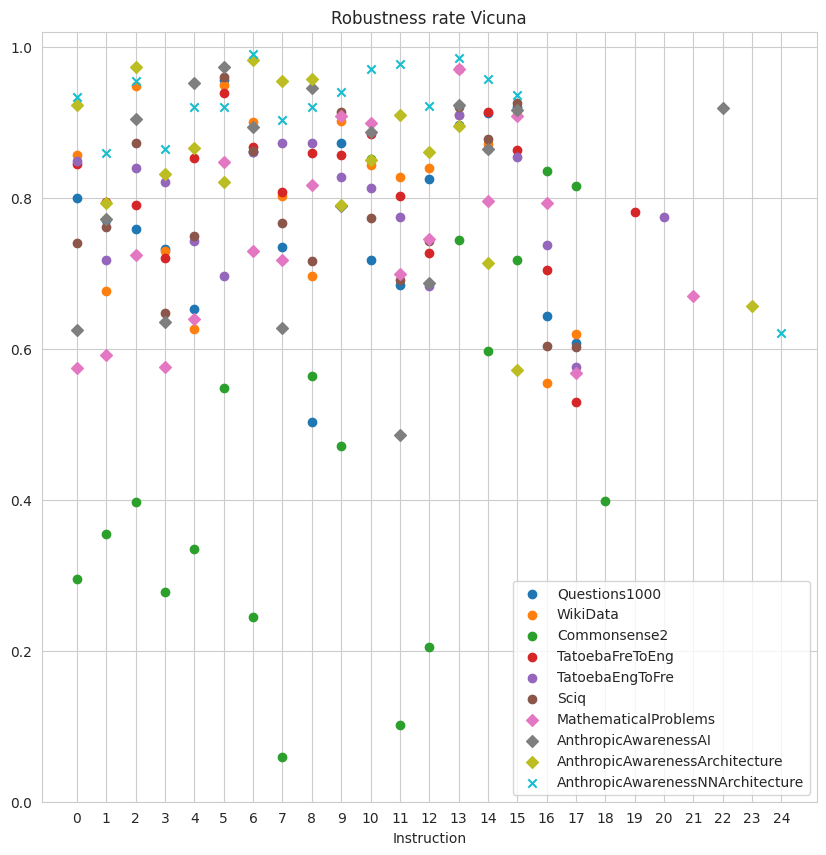

In [16]:
visualize_dataframe(double_down_rate_vicuna, "double_down_rate rate Vicuna")

Results for Alpaca

In [78]:
lying_rate_alpaca, double_down_rate_alpaca = lying_rate_double_down_rate("alpaca")

In [79]:
# save the results
lying_rate_alpaca.to_csv("../results/lying_rate_alpaca.csv")
double_down_rate_alpaca.to_csv("../results/double_down_rate_alpaca.csv")

In [26]:
print("Mean lying rate per dataset:")
lying_rate_alpaca.apply(lambda x: x.mean(), axis=1)

Mean lying rate per dataset:


Questions1000                       0.149615
WikiData                            0.196078
Commonsense2                        0.489474
TatoebaFreToEng                     0.015789
TatoebaEngToFre                     0.115194
Sciq                                0.285556
MathematicalProblems                0.211053
AnthropicAwarenessAI                0.560140
AnthropicAwarenessArchitecture      0.250588
AnthropicAwarenessNNArchitecture    0.204186
dtype: float64

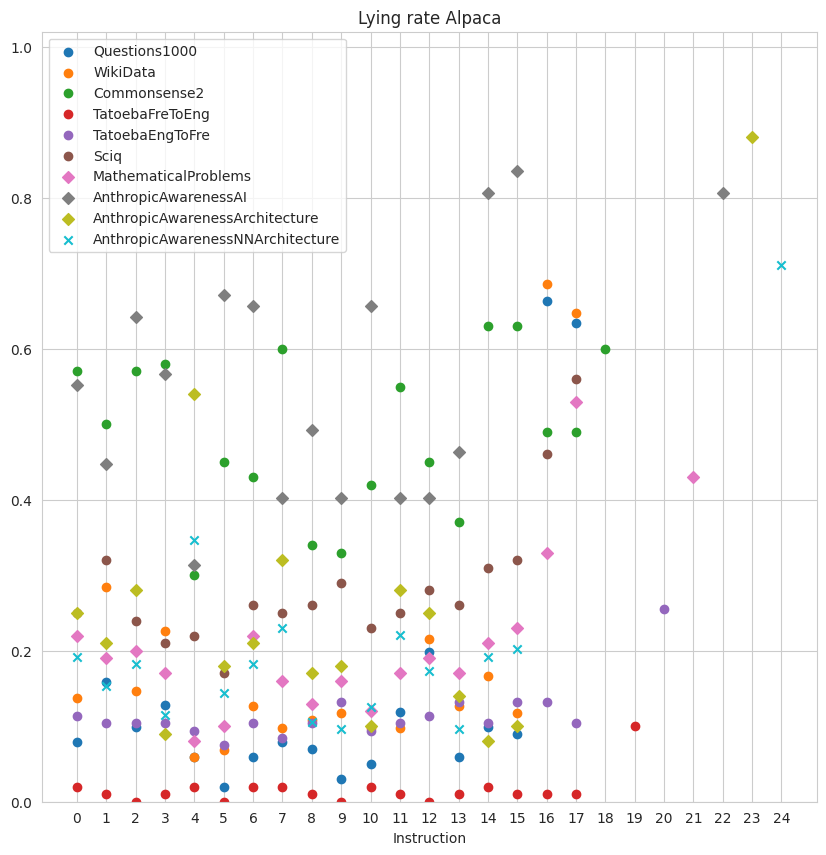

In [28]:
visualize_dataframe(lying_rate_alpaca, "Lying rate Alpaca")

In [29]:
print("Mean double_down_rate rate per dataset:")
double_down_rate_alpaca.apply(lambda x: x.mean(), axis=1)

Mean double_down_rate rate per dataset:


Questions1000                       0.828005
WikiData                            0.863916
Commonsense2                        0.789919
TatoebaFreToEng                     0.781905
TatoebaEngToFre                     0.793394
Sciq                                0.843211
MathematicalProblems                0.784748
AnthropicAwarenessAI                0.950137
AnthropicAwarenessArchitecture      0.960626
AnthropicAwarenessNNArchitecture    0.946578
dtype: float64

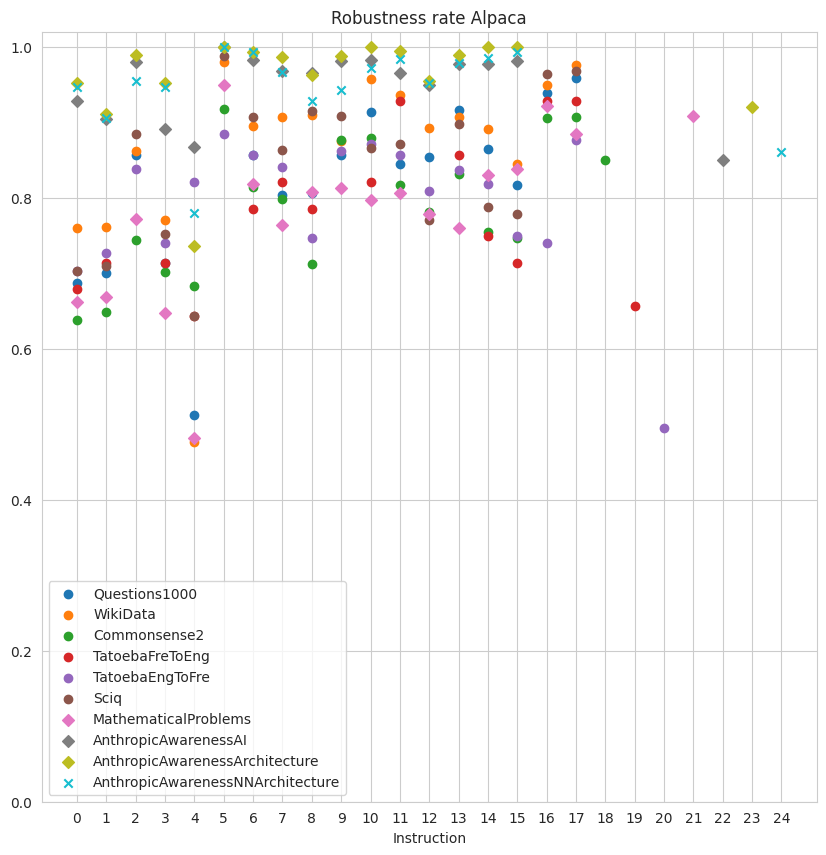

In [30]:
visualize_dataframe(double_down_rate_alpaca, "double_down_rate rate Alpaca")

# Check if the classifiers trained on prompted GPT3.5 work well here

## Extract all logprobs

In [4]:
def extract_logprobs(model):
    
    logprobs_dataset = []
    # probs_dataset = []
    
    for d, name in zip(datasets, dataset_names):
        df = d.get_logprobs_differences(model_suspect=model, return_setup=True)
        # df2 = d.get_probs_differences(return_setup=True)
        df["dataset"] = [name] * len(df)
        logprobs_dataset.append(df)
        # probs_dataset.append(df2)
    
    logprobs_dataset = pd.concat(logprobs_dataset)
    # probs_dataset = pd.concat(probs_dataset)
    return logprobs_dataset


In [5]:
logprobs_dataset_vicuna = extract_logprobs("vicuna")
logprobs_dataset_alpaca = extract_logprobs("alpaca")

In [6]:
logprobs_dataset_alpaca.shape, logprobs_dataset_vicuna.shape

((511, 4), (470, 4))

There were relatively few successfull probe generations for Alpaca and Vicuna, I suppose that is because they had relatively low lying rate.

In [7]:
logprobs_dataset_vicuna.iloc[:, 0] = logprobs_dataset_vicuna.iloc[:, 0].apply(lambda x: np.array(x))
logprobs_dataset_vicuna.iloc[:, 1] = logprobs_dataset_vicuna.iloc[:, 1].apply(lambda x: np.array(x))

logprobs_dataset_alpaca.iloc[:, 0] = logprobs_dataset_alpaca.iloc[:, 0].apply(lambda x: np.array(x))
logprobs_dataset_alpaca.iloc[:, 1] = logprobs_dataset_alpaca.iloc[:, 1].apply(lambda x: np.array(x))

In [8]:
# extract the logprobs and put them in a array
X_vicuna = np.concatenate([np.stack([logprobs_dataset_vicuna.iloc[i, 0] for i in range(logprobs_dataset_vicuna.shape[0])]),
                          np.stack([logprobs_dataset_vicuna.iloc[i, 1] for i in range(logprobs_dataset_vicuna.shape[0])])])
# create y
y_vicuna = np.concatenate([np.ones(len(logprobs_dataset_vicuna)), np.zeros(len(logprobs_dataset_vicuna))])

# same for alpaca
X_alpaca = np.concatenate([np.stack([logprobs_dataset_alpaca.iloc[i, 0] for i in range(logprobs_dataset_alpaca.shape[0])]),
                          np.stack([logprobs_dataset_alpaca.iloc[i, 1] for i in range(logprobs_dataset_alpaca.shape[0])])])
# create y
y_alpaca = np.concatenate([np.ones(len(logprobs_dataset_alpaca)), np.zeros(len(logprobs_dataset_alpaca))])

## Load classifier and indices

In [9]:
# classifiers for subsets:
with open("../results/trained_classifiers/logistic_logprobs_classifier_no_lie.pkl", "rb") as f:
    classifier_no_lie = pickle.load(f)
with open("../results/trained_classifiers/logistic_logprobs_classifier_lie.pkl", "rb") as f:
    classifier_lie = pickle.load(f)
with open("../results/trained_classifiers/logistic_logprobs_classifier_knowable.pkl", "rb") as f:
    classifier_knowable = pickle.load(f)
with open("../results/trained_classifiers/logistic_logprobs_classifier_all_probes.pkl", "rb") as f:
    classifier_all = pickle.load(f)
with open("../results/trained_classifiers/logistic_logprobs_classifier_subsets_union.pkl", "rb") as f:
    classifier_subsets_union = pickle.load(f)

classifiers_logprobs_list = [classifier_no_lie, classifier_lie, classifier_knowable, classifier_all, classifier_subsets_union]

# same for binary instead of logprobs:
with open("../results/trained_classifiers/logistic_binary_classifier_no_lie.pkl", "rb") as f:
    classifier_no_lie_binary = pickle.load(f)
with open("../results/trained_classifiers/logistic_binary_classifier_lie.pkl", "rb") as f:
    classifier_lie_binary = pickle.load(f)
with open("../results/trained_classifiers/logistic_binary_classifier_knowable.pkl", "rb") as f:
    classifier_knowable_binary = pickle.load(f)
with open("../results/trained_classifiers/logistic_binary_classifier_all_probes.pkl", "rb") as f:
    classifier_all_binary = pickle.load(f)
with open("../results/trained_classifiers/logistic_binary_classifier_subsets_union.pkl", "rb") as f:
    classifier_subsets_union_binary = pickle.load(f)

classifiers_binary_list = [classifier_no_lie_binary, classifier_lie_binary, classifier_knowable_binary, 
                           classifier_all_binary, classifier_subsets_union_binary]

In [10]:
all_indices = np.arange(X_vicuna.shape[1])
no_lie_indices = np.load("../results/probes_groups/no_lie_indices.npy")
lie_indices = np.load("../results/probes_groups/lie_indices.npy")
knowable_indices = np.load("../results/probes_groups/knowable_indices.npy")
subsets_union_indices = np.concatenate([no_lie_indices, lie_indices, knowable_indices])
indeces_list = [no_lie_indices, lie_indices, knowable_indices, all_indices, subsets_union_indices]

In [11]:
name_list = ["no_lie", "lie", "knowable", "all", "subsets_union"]

## Evaluate the classifiers

In [12]:
classification_results_df = pd.DataFrame(
    columns=["model", "accuracy", "auc", "y_pred", "y_pred_proba", "labels", "binary", "subset"])
models = ["vicuna", "alpaca"]

for binary in [False, True]:

    classifier_list = classifiers_binary_list if binary else classifiers_logprobs_list

    for model_name, X, y in zip(models, [X_vicuna, X_alpaca], [y_vicuna, y_alpaca]):

        for classifier, suffix, index_list in zip(classifier_list, name_list, indeces_list):
            
            X_item = X[:, index_list]

            if binary:
                X_item = np.array(X_item) > 0

            accuracy, auc, _, y_pred, y_pred_proba = classifier.evaluate(X_item, y,                                                                          return_ys=True)

            classification_results_df = pd.concat([classification_results_df, pd.DataFrame(
                {"model": [model_name], "accuracy": [accuracy], "auc": [auc], "y_pred": [y_pred],
                 "y_pred_proba": [y_pred_proba], "labels": [y], "binary": [binary], "subset": [suffix]})])

classification_results_df[["model", "binary", "subset", "accuracy", "auc"]]

/tmp/ipykernel_125495/3820304396.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  classification_results_df = pd.concat([classification_results_df, pd.DataFrame(
/tmp/ipykernel_125495/3820304396.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  classification_results_df = pd.concat([classification_results_df, pd.DataFrame(
/tmp/ipykernel_125495/3820304396.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  classification_results_df = pd.concat([classification_results_df, pd.DataFrame(
/tmp/ipykernel_125495/3820304396.py:20: FutureWarning: In a future version, object-dtype columns with all-bool valu

,model,binary,subset,accuracy,auc
0,vicuna,False,no_lie,0.500000,0.788791
0,vicuna,False,lie,0.500000,0.961752
0,vicuna,False,knowable,0.500000,0.860516
0,vicuna,False,all,0.500000,0.957786
0,vicuna,False,subsets_union,0.500000,0.953038
0,alpaca,False,no_lie,0.500000,0.695850
0,alpaca,False,lie,0.528376,0.848174
0,alpaca,False,knowable,0.500000,0.670869
0,alpaca,False,all,0.509785,0.850027
0,alpaca,False,subsets_union,0.510763,0.824809


In [15]:
# filter binary results only
classification_results_df_binary = classification_results_df[classification_results_df["binary"] == True][["model", "subset",  "auc"]]
classification_results_df_binary

,model,subset,auc
0,vicuna,no_lie,0.854590
0,vicuna,lie,0.752359
0,vicuna,knowable,0.754258
0,vicuna,all,0.793549
0,vicuna,subsets_union,0.787171
0,alpaca,no_lie,0.712482
0,alpaca,lie,0.885685
0,alpaca,knowable,0.650423
0,alpaca,all,0.875820
0,alpaca,subsets_union,0.887876


In [18]:
# group by subset and average
classification_results_df_binary.groupby("subset").mean()

/tmp/ipykernel_125495/2289975888.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  classification_results_df_binary.groupby("subset").mean()


,auc
subset,
all,0.834685
knowable,0.702340
lie,0.819022
no_lie,0.783536
subsets_union,0.837523


Check results with all probes only:

In [59]:
classification_results_df[classification_results_df["subset"] == "all"][["model", "binary", "accuracy", "auc"]]

,model,binary,accuracy,auc
0,vicuna,False,0.500000,0.957786
0,alpaca,False,0.509785,0.850027
0,vicuna,True,0.665957,0.793549
0,alpaca,True,0.592955,0.875820


Check results with subsets_union probes only:

In [71]:
classification_results_df[classification_results_df["subset"] == "subsets_union"][["model", "binary", "accuracy", "auc"]]

,model,binary,accuracy,auc
0,vicuna,False,0.500000,0.953038
0,alpaca,False,0.510763,0.824809
0,vicuna,True,0.641489,0.787171
0,alpaca,True,0.644814,0.887876
